## Libraries

In [1]:
# Python 3.12.7
# Windows 11, 64-bit
# CUDA-device: NVIDIA GeForce RTX 4060 Laptop GPU

# ! pip install transformers torch shap pandas matplotlib datasets plotly
import pandas as pd
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import Dataset
import torch
import numpy as np
import json
import os
from collections import defaultdict
from decimal import Decimal
import plotly.graph_objects as go
import textwrap
import matplotlib.pyplot as plt

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")


c:\Users\Timur\Documents\Python_Scripts\AI\SHAP_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


## Model & Pipeline

In [2]:
# Load the multilingual DistilBERT sentiment model
MODEL_NAME = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
device = "cuda"

# Hugging Face pipeline for sentiment analysis
sentiment_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    device=device
)

# Helper: Map class indices to sentiment labels
sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
explainer = shap.Explainer(sentiment_pipeline)

Device set to use cuda


## Functions

In [3]:
# Functions 
def explain_parallel_texts(df, text_columns, explainer, sample_size=None):
    """
    Process parallel translations while keeping their relationships intact
    
    Parameters:
    - df: DataFrame containing parallel texts
    - text_columns: list of language columns to process
    - explainer: SHAP explainer instance
    - sample_size: optionally limit number of samples
    """
    results = {}
    
    # Process each language separately but maintain original order
    for lang in text_columns:
        texts = df[lang].dropna().tolist()
        if sample_size:
            texts = texts[:sample_size]
        
        # Convert to Dataset for efficient processing
        lang_dataset = Dataset.from_dict({"text": texts})
        results[lang] = {
            "texts": texts,
            "explanations": explainer(lang_dataset["text"])
        }
    
    # Add metadata about parallel relationships
    results["parallel_ids"] = df["id"].tolist() if "id" in df.columns else list(range(len(texts)))
    
    return results

def extract_top_class_explanations(results):
    """
    Processes SHAP results to keep only explanations for the most confident class.

    Args:
        results: Dictionary containing language-wise SHAP explanations
                (your existing movie_results or legal_results)

    Returns:
        Dictionary with same structure but values only for predicted class
    """
    simplified_results = {}

    for lang in [k for k in results.keys() if k != 'parallel_ids']:
        lang_data = results[lang]
        simplified_explanations = []

        for i, explanation in enumerate(lang_data['explanations']):
            # Get the pipeline output for the current text
            pipeline_output = sentiment_pipeline(lang_data['texts'][i])

            # Extract the score and label of the most confident class
            predicted_class_info = pipeline_output[0][0]
            predicted_class_label = predicted_class_info['label']
            predicted_class_score = predicted_class_info['score']

            # Map the label to the class index using sentiment_map
            predicted_class = [k for k, v in sentiment_map.items() if v == predicted_class_label][0]

            # Extract SHAP values only for this class
            class_shap_values = explanation.values[:, predicted_class]

            # Store simplified explanation
            simplified_explanations.append({
                'text': lang_data['texts'][i],
                'predicted_class': predicted_class,
                'class_name': predicted_class_label,
                'confidence': predicted_class_score,
                'shap_values': class_shap_values,
                'tokens': explanation.data
            })

        simplified_results[lang] = simplified_explanations

    # Preserve parallel IDs if needed
    if 'parallel_ids' in results:
        simplified_results['parallel_ids'] = results['parallel_ids']

    return simplified_results

def add_word_level_explanations(results, tokenizer, dataset_name="movie"):
    """
    Enhance SHAP results with word-level explanations and save processing logs.
    
    Args:
        results: Dictionary containing language-wise SHAP explanations 
        tokenizer: The HuggingFace tokenizer instance
        dataset_name: Prefix for log files ('movie' or 'legal')
    
    Returns:
        Dictionary with added 'words' and 'word_shap_values' for each entry
    """
    # Create logs directory if needed
    os.makedirs("shap_logs", exist_ok=True)
    
    for lang in [k for k in results.keys() if k != 'parallel_ids']:
        for i, entry in enumerate(results[lang]):
            # Generate log filename
            log_file = f"shap_logs/{dataset_name}_{lang}_{i}.txt"
            
            # Process with UTF-8 encoded logging
            with open(log_file, 'w', encoding='utf-8') as f:  # Explicit UTF-8 encoding
                word_contributions = process_single_text(
                    text=entry['text'],
                    shap_values=entry['shap_values'],
                    tokens=entry['tokens'],
                    tokenizer=tokenizer,
                    log_file=f
                )
            
            # Add to original results
            entry['words'] = list(word_contributions.keys())
            entry['word_shap_values'] = list(word_contributions.values())

    return results

def process_single_text(text, shap_values, tokens, tokenizer, log_file):
    """Process one text entry with detailed logging."""
    def log(msg):
        print(msg)
        if log_file:  # Only write to file if it exists
            print(msg, file=log_file)
    
    log(f"\n=== Processing text ===\n{text}\n")
    
    # Tokenize with character-level offsets
    inputs = tokenizer(text, return_offsets_mapping=True)
    offsets = inputs["offset_mapping"]
    
    log("\nTokenization details:")
    log(f"{'Token':<15} | {'Text':<20} | {'Start':<5} | {'End':<5} | {'SHAP Value':<12}")
    log("-" * 70)
    for idx, ((start, end), shap_val) in enumerate(zip(offsets, shap_values)):
        token_text = text[start:end] if start != end else tokens[idx]
        log(f"{tokens[idx]:<15} | {repr(token_text):<20} | {start:<5} | {end:<5} | {shap_val:+.6f}")
    
    # Reconstruct words using whitespace boundaries
    word_contributions = {}
    current_word = ""
    current_contrib = 0.0
    word_start = None
    
    # Get all whitespace positions
    whitespaces = [i for i, char in enumerate(text) if char == ' ']
    whitespaces.append(len(text))  # Add end of string
    
    for token_idx, (token, (start, end)) in enumerate(zip(tokens, offsets)):
        # Skip special tokens
        if start == end == 0:
            continue
            
        # New word starts when we pass a whitespace
        if word_start is None or start >= whitespaces[0]:
            # Save previous word
            if current_word:
                word_contributions[current_word] = current_contrib
                log(f"\nSaved word: '{current_word}' with SHAP {current_contrib:+.6f}")
            
            # Start new word
            current_word = ""
            current_contrib = 0.0
            word_start = start
            # Remove used whitespace
            while whitespaces and start >= whitespaces[0]:
                whitespaces.pop(0)
        
        # Add to current word
        token_text = text[start:end] if start != end else token
        current_word += token_text
        current_contrib += shap_values[token_idx]
        log(f"  Added token '{token}' ({start}-{end}) as '{token_text}'")
    
    # Add the last word
    if current_word:
        word_contributions[current_word] = current_contrib
        log(f"\nSaved final word: '{current_word}' with SHAP {current_contrib:+.6f}")
    
    # Replace arrows with text for better compatibility
    log("\n=== Final Word Contributions ===")
    for word, contrib in sorted(word_contributions.items(), key=lambda x: abs(x[1]), reverse=True):
        direction = "POS" if contrib > 0 else "NEG"  # Changed from arrows to text
        log(f"{word:<25} {contrib:+.6f} ({direction})")
    
    return word_contributions

def numpy_encoder(obj):
    """Convert NumPy types to Python native types for JSON serialization."""
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    if isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

def visualize_shap_explanation(entry, max_line_length=80):
    """
    Visualize word-level SHAP explanations for a single text entry.

    Args:
        entry: Dictionary containing:
               - text: Original text
               - words: List of words
               - word_shap_values: Corresponding SHAP values
               - class_name: Predicted sentiment class
               - confidence: Prediction confidence
        max_line_length: Maximum characters per line
    """
    text = entry['text']
    words = entry['words']
    word_shap_values = [float(value) for value in entry['word_shap_values']]
    predicted_class = entry['class_name']
    confidence = float(entry['confidence'])

    # Create word-to-SHAP mapping
    word_contributions = dict(zip(words, word_shap_values))

    # Text wrapping
    lines = textwrap.wrap(text, width=max_line_length)

    fig = go.Figure()

    # Layout parameters
    y_pos = 1.0
    char_width = 0.015
    line_height = 0.15
    line_spacing = 1.2

    # Split lines into words with punctuation handling
    def split_words(t):
        words = []
        current_word = ""
        for char in t + " ":
            if char.isalnum() or char in "'-":
                current_word += char
            else:
                if current_word:
                    words.append(current_word)
                    current_word = ""
                if char != " ":
                    if words:
                        words[-1] += char
        return words

    shapes = []
    annotations = []
    hover_data = []

    # Calculate max absolute SHAP for scaling
    max_abs_shap = max(abs(min(word_shap_values)), abs(max(word_shap_values)))

    for line in lines:
        line_words = split_words(line)
        x_pos = 0.01

        for word in line_words:
            # Get SHAP value (check both raw and cleaned variants)
            contrib = word_contributions.get(word, word_contributions.get(word.strip(".,!?;:\"'"), 0))

            word_width = len(word) * char_width

            # Color calculation based on predicted_class
            alpha = min(abs(contrib) / max_abs_shap, 1) if max_abs_shap > 0 else 0

            if predicted_class in ["Positive", "Very Positive"]:
                positive_color = f"rgba(0, 128, 0, {alpha})"  # Green
                negative_color = f"rgba(255, 0, 0, {alpha})"  # Red
                comment = "Red - supposedly negative words, Green - supposedly positive words"
            elif predicted_class in ["Negative", "Very Negative"]:
                positive_color = f"rgba(255, 0, 0, {alpha})"  # Red
                negative_color = f"rgba(0, 128, 0, {alpha})"  # Green
                comment = "Red - supposedly negative words, Green - supposedly positive words"
            elif predicted_class == "Neutral":
                positive_color = f"rgba(255, 165, 0, 0)"  # Transparent
                negative_color = f"rgba(255, 165, 0, {alpha})"   # Orange
                comment = "Orange - supposedly non-neutral words, Transparent - supposedly neutral words"

            # Assign color based on contribution
            color = negative_color if contrib < 0 else positive_color

            # Add colored rectangle
            shapes.append(
                dict(
                    type="rect",
                    x0=x_pos,
                    y0=y_pos - line_height/2,
                    x1=x_pos + word_width,
                    y1=y_pos + line_height/2,
                    fillcolor=color,
                    line=dict(width=0)
                )
            )

            # Add visible word text
            annotations.append(
                dict(
                    x=x_pos + word_width/2,
                    y=y_pos,
                    text=word,
                    showarrow=False,
                    font=dict(size=14, color='black')
                )
            )

            # Store hover data with clear interpretation
            direction = "against" if (contrib < 0) else "for"
            hover_data.append({
                'pos': (x_pos + word_width/2, y_pos),
                'text': (
                    f"Word: {word}<br>"
                    f"SHAP value: {contrib:.3f}<br>"
                    f"Works {direction} <b>{predicted_class}</b> prediction<br>"
                )
            })

            x_pos += word_width + (char_width/2)

        y_pos -= line_height * line_spacing

    # Add invisible hover points
    fig.add_trace(
        go.Scatter(
            x=[d['pos'][0] for d in hover_data],
            y=[d['pos'][1] for d in hover_data],
            text=[d['text'] for d in hover_data],
            mode="markers",
            marker=dict(size=10, opacity=0),
            hoverinfo="text",
            showlegend=False,
            hoverlabel=dict(
                bgcolor="white",
                font_size=12,
                font_family="Arial"
            )
        )
    )

    # Configure layout
    fig.update_layout(
        shapes=shapes,
        annotations=annotations,
        plot_bgcolor="white",
        xaxis=dict(showgrid=False, zeroline=False, range=[0, 1], visible=False),
        yaxis=dict(showgrid=False, zeroline=False, range=[y_pos - line_height*2, 1.1], visible=False),
        margin=dict(l=20, r=20, t=60, b=0.1),
        title=(
            f"Predicted: {predicted_class} ({confidence:.1%} confidence)<br>"
            f"<sup>{comment}</sup>"
        ),
        hoverdistance=20,
        showlegend=False
    )

    fig.show()


## Explain the predictions

### Movie parallel subtitles

In [4]:
# Load your datasets
df_movie = pd.read_csv("movie.csv")       # Columns: id, english, russian, italian

# Process datasets with parallel structure preserved (token-level explanations)
movie_results = explain_parallel_texts(df_movie, ["english", "russian", "italian"], explainer)

# Extract top class explanation
simple_movie = extract_top_class_explanations(movie_results)

# Word-level explanations (+logs)
simple_movie = add_word_level_explanations(simple_movie, tokenizer, "movie")

# Save to JSON file
with open('simple_movie.json', 'w', encoding='utf-8') as f:
    json.dump(simple_movie, f, indent=2, ensure_ascii=False, default=numpy_encoder)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 26it [01:18,  3.15s/it]                        
PartitionExplainer explainer: 26it [00:39,  2.17s/it]                        
PartitionExplainer explainer: 26it [00:41,  2.19s/it]                        



=== Processing text ===
Mathematicians won the war. Mathematicians broke the Japanese codes and built the A-bomb. Mathematicians, like you.


Tokenization details:
Token           | Text                 | Start | End   | SHAP Value  
----------------------------------------------------------------------
                | ''                   | 0     | 0     | +0.000000
Math            | 'Math'               | 0     | 4     | +0.007547
ema             | 'ema'                | 4     | 7     | +0.005923
tician          | 'tician'             | 7     | 13    | +0.018786
s               | 's'                  | 13    | 14    | +0.000399
won             | 'won'                | 15    | 18    | -0.056389
the             | 'the'                | 19    | 22    | -0.014218
war             | 'war'                | 23    | 26    | +0.089403
.               | '.'                  | 26    | 27    | +0.018657
Math            | 'Math'               | 28    | 32    | +0.009696
ema             | 'ema' 

### AI Act Parallel

In [5]:
# Load your datasets
df_legal = pd.read_csv("ai_act.csv")      # Columns: id, article, english, italian

# Process datasets with parallel structure preserved (token-level explanations)
legal_results = explain_parallel_texts(df_legal, ["english", "italian"], explainer)

# Extract top class explanation
simple_legal = extract_top_class_explanations(legal_results)

# Word-level explanations (+logs)
simple_legal = add_word_level_explanations(simple_legal, tokenizer, "legal")

# Save to JSON file
with open('simple_legal.json', 'w', encoding='utf-8') as f:
    json.dump(simple_legal, f, indent=2, ensure_ascii=False, default=numpy_encoder)

PartitionExplainer explainer: 26it [00:49,  2.47s/it]                        
PartitionExplainer explainer: 26it [00:59,  2.95s/it]                        



=== Processing text ===
to promote the uptake of human centric and trustworthy artificial intelligence (AI) while ensuring a high level of protection of health, safety, fundamental rights as enshrined in the Charter of Fundamental Rights of the European Union (the ‘Charter’), including democracy, the rule of law and environmental protection, to protect against the harmful effects of AI systems in the Union, and to support innovation.


Tokenization details:
Token           | Text                 | Start | End   | SHAP Value  
----------------------------------------------------------------------
                | ''                   | 0     | 0     | +0.000785
to              | 'to'                 | 0     | 2     | +0.000785
promote         | 'promote'            | 3     | 10    | -0.000510
the             | 'the'                | 11    | 14    | -0.000510
up              | 'up'                 | 15    | 17    | +0.001851
take            | 'take'               | 17    | 21    | +0.0

## Visualization

### Load the data (optional)

In [6]:
with open('simple_legal.json', 'r', encoding='utf-8') as f:
    simple_legal1 = json.load(f, parse_float=Decimal)

with open('simple_movie.json', 'r', encoding='utf-8') as f:
    simple_movie1 = json.load(f, parse_float=Decimal)

### Custom Visualization

In [7]:
i = 0
visualize_shap_explanation(simple_movie1['english'][i])
visualize_shap_explanation(simple_movie1['russian'][i])
visualize_shap_explanation(simple_movie1['italian'][i])


### Visualisation in SHAP


SHAP Force Plot for English text:
Predicted: Very Negative (Confidence: 39.2%)


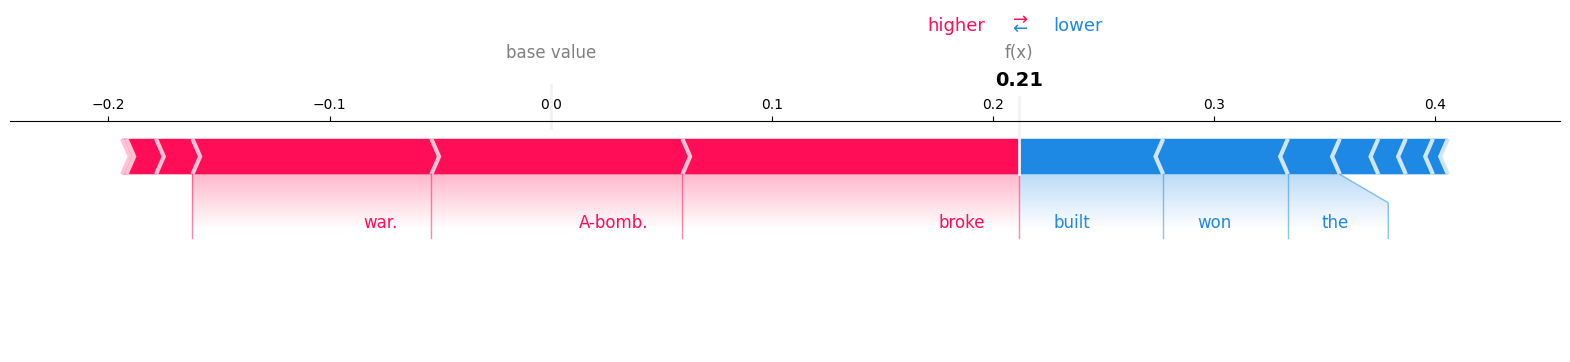


SHAP Force Plot for Russian text:
Predicted: Very Negative (Confidence: 50.1%)


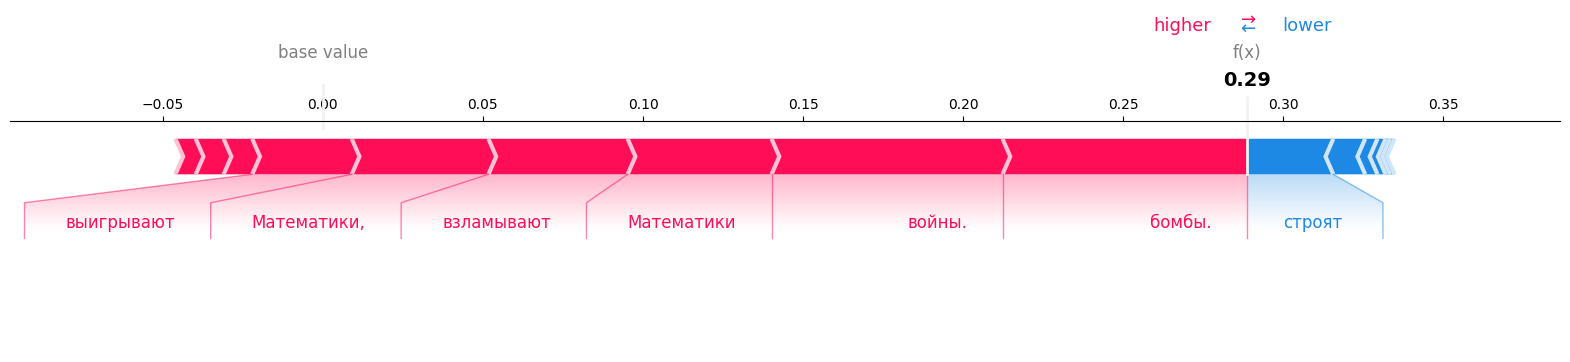


SHAP Force Plot for Italian text:
Predicted: Positive (Confidence: 32.3%)


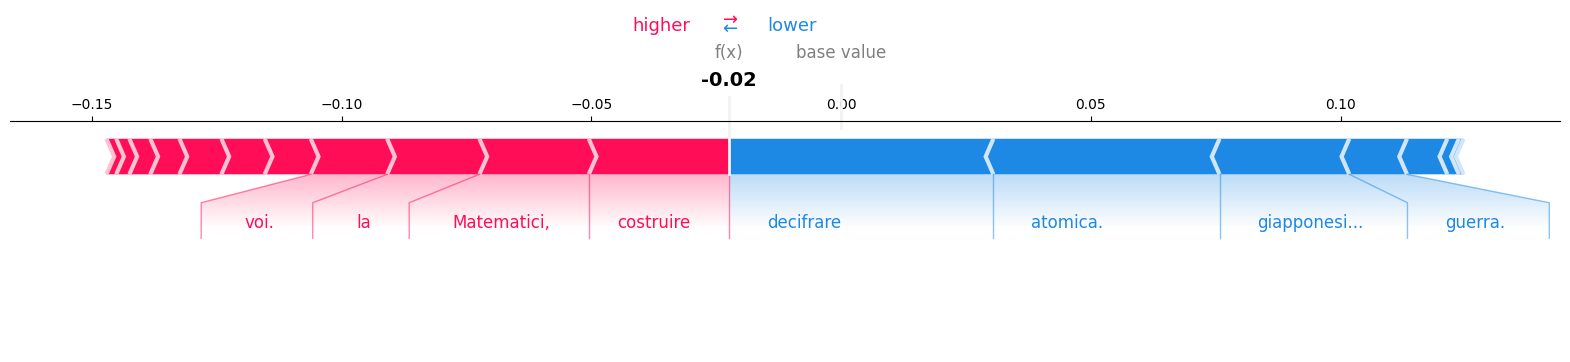

In [8]:
# Force Plot - shows how each feature contributes to pushing the model output from the base value to the prediction
for lang in ['english', 'russian', 'italian']:
    entry = simple_movie1[lang][i]
    
    # Create SHAP values array for the predicted class
    shap_values = np.array([float(val) for val in entry['word_shap_values']])
    words = entry['words']
    
    print(f"\nSHAP Force Plot for {lang.capitalize()} text:")
    print(f"Predicted: {entry['class_name']} (Confidence: {float(entry['confidence']):.1%})")
    shap.force_plot(
        base_value=0,  # base value (expected value) for this model output
        shap_values=shap_values,
        features=words,
        show=True,
        matplotlib=True
    )
    plt.show()
